In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import pickle
import math
import scipy
from sklearn import linear_model, datasets

from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
from PIL import Image
import torch

from helpers import *
import database as Database

image_scale = 0.2

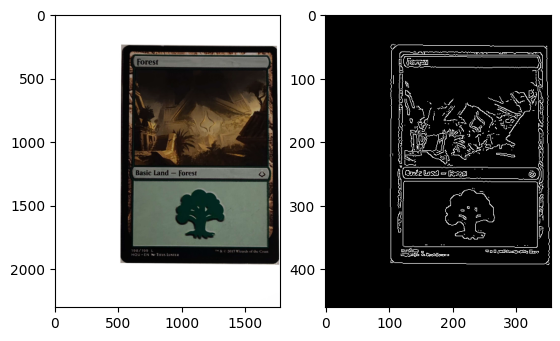

In [13]:
cards = os.listdir("cards")
card_dir = "IMG_20230508_225012.jpg"
img = cv.imread(f"cards/{card_dir}")
_, edges = detect_edges(img)

plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(edges,cv.COLOR_BGR2RGB))

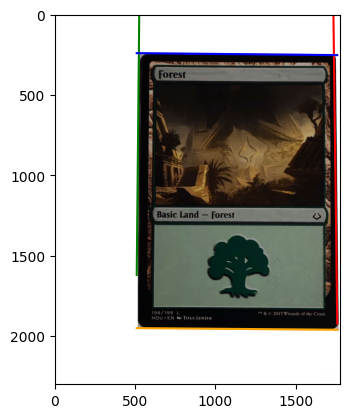

In [11]:
def ransac_corner_detection(img, edges):
    global image_scale
    ransac = linear_model.RANSACRegressor()

    # Find the points along the right edge
    right_col  = []
    left_col   = []
    bottom_row = []
    top_row    = []

    for i, row in enumerate(edges):
        # Find all white pixel points
        points = [(i,j) for j, pixel in enumerate(row) if pixel > 200]
        if len(points) == 0:
            continue

        # Organise by largest to smallest
        points.sort(key=lambda x: x[1], reverse=True)   
        right_col.append(points[0])
        left_col.append(points[-1])
    
    for j, row in enumerate(edges.T):
        # Find all white pixel points
        points = [(i,j) for i, pixel in enumerate(row) if pixel > 200]
        if len(points) == 0:
            continue

        # Organise by largest to smallest
        points.sort(key=lambda x: x[1], reverse=True)   
        top_row.append(points[0])
        bottom_row.append(points[-1])

    # Arrange points for each side
    right_X,  right_y   = np.array([x/image_scale for _, x in right_col ]).reshape(-1, 1), np.array([y/image_scale for y,_ in right_col ]).reshape(-1, 1)
    left_X,   left_y    = np.array([x/image_scale for _, x in left_col  ]).reshape(-1, 1), np.array([y/image_scale for y,_ in left_col  ]).reshape(-1, 1)
    bottom_X, bottom_y  = np.array([x/image_scale for _, x in bottom_row]).reshape(-1, 1), np.array([y/image_scale for y,_ in bottom_row]).reshape(-1, 1)
    top_X,    top_y     = np.array([x/image_scale for _, x in top_row   ]).reshape(-1, 1), np.array([y/image_scale for y,_ in top_row   ]).reshape(-1, 1)

    # Compute ransac for Right edge #
    ransac.fit(right_X, right_y)
    line_X_right = np.arange(right_X.min(), right_X.max())[:, np.newaxis]
    line_y_right = ransac.predict(line_X_right)

    # Compute ransac for left edge #
    ransac.fit(left_X, left_y)
    line_X_left = np.arange(left_X.min(), left_X.max())[:, np.newaxis]
    line_y_left = ransac.predict(line_X_left)

    # Compute ransac for bottom edge #
    ransac.fit(bottom_X, bottom_y)
    line_X_bottom = np.arange(bottom_X.min(), bottom_X.max())[:, np.newaxis]
    line_y_bottom = ransac.predict(line_X_bottom)

    # Compute ransac for top edge #
    ransac.fit(top_X, top_y)
    line_X_top = np.arange(top_X.min(), top_X.max())[:, np.newaxis]
    line_y_top = ransac.predict(line_X_top)

    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.plot(line_X_right, line_y_right, color="red")
    plt.plot(line_X_left, line_y_left, color="green")
    plt.plot(line_X_bottom, line_y_bottom, color="orange")
    plt.plot(line_X_top, line_y_top, color="blue")
    plt.xlim([0, len(img[0])])
    plt.ylim([0,len(img)])
    plt.gca().invert_yaxis()
    plt.show()

    return line_X_right, line_y_right

img = cv.imread(f"cards/{card_dir}")
_, edges = detect_edges(img)
line_X_right, line_y_right = ransac_corner_detection(img, edges)

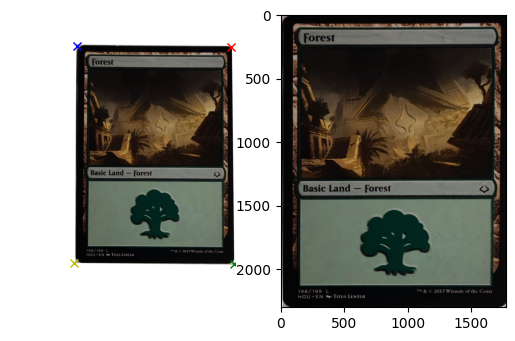

In [14]:
def ransac_corner_detection(img, edges):
    global image_scale
    ransac = linear_model.RANSACRegressor()

    # Find the points along the right edge
    right_col  = []
    left_col   = []
    bottom_row = []
    top_row    = []

    for i, row in enumerate(edges):
        # Find all white pixel points
        points = [(i,j) for j, pixel in enumerate(row) if pixel > 200]
        if len(points) == 0:
            continue

        # Organise by largest to smallest
        points.sort(key=lambda x: x[1], reverse=True)   
        right_col.append(points[0])
        left_col.append(points[-1])
    
    for j, row in enumerate(edges.T):
        # Find all white pixel points
        points = [(i,j) for i, pixel in enumerate(row) if pixel > 200]
        if len(points) == 0:
            continue

        # Organise by largest to smallest
        points.sort(key=lambda x: x[1], reverse=True)   
        top_row.append(points[0])
        bottom_row.append(points[-1])

    # Arrange points for each side
    right_X,  right_y   = np.array([x/image_scale for _, x in right_col ]).reshape(-1, 1), np.array([y/image_scale for y,_ in right_col ]).reshape(-1, 1)
    left_X,   left_y    = np.array([x/image_scale for _, x in left_col  ]).reshape(-1, 1), np.array([y/image_scale for y,_ in left_col  ]).reshape(-1, 1)
    bottom_X, bottom_y  = np.array([x/image_scale for _, x in bottom_row]).reshape(-1, 1), np.array([y/image_scale for y,_ in bottom_row]).reshape(-1, 1)
    top_X,    top_y     = np.array([x/image_scale for _, x in top_row   ]).reshape(-1, 1), np.array([y/image_scale for y,_ in top_row   ]).reshape(-1, 1)

    # Compute ransac for Right edge #
    ransac.fit(right_X, right_y)
    right_coef      = ransac.estimator_.coef_
    right_intercept = ransac.estimator_.intercept_

    # Compute ransac for left edge #
    ransac.fit(left_X, left_y)
    left_coef = ransac.estimator_.coef_
    left_intercept = ransac.estimator_.intercept_

    # Compute ransac for bottom edge #
    ransac.fit(bottom_X, bottom_y)
    bottom_coef = ransac.estimator_.coef_
    bottom_intercept = ransac.estimator_.intercept_

    # Compute ransac for top edge #
    ransac.fit(top_X, top_y)
    top_coef = ransac.estimator_.coef_
    top_intercept = ransac.estimator_.intercept_

    # Calculate corner location estimates
    top_right_x = (right_intercept - top_intercept) / (top_coef - right_coef)
    top_right_y = top_coef * top_right_x + top_intercept

    top_left_x = (left_intercept - top_intercept) / (top_coef - left_coef)
    top_left_y = top_coef * top_left_x + top_intercept

    bottom_right_x = (right_intercept - bottom_intercept) / (bottom_coef - right_coef)
    bottom_right_y = bottom_coef * bottom_right_x + bottom_intercept

    bottom_left_x = (left_intercept - bottom_intercept) / (bottom_coef - left_coef)
    bottom_left_y = bottom_coef * bottom_left_x + bottom_intercept

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.plot(top_right_x, top_right_y,'rx') 
    plt.plot(top_left_x, top_left_y,'bx') 
    plt.plot(bottom_right_x, bottom_right_y,'gx') 
    plt.plot(bottom_left_x, bottom_left_y,'yx')

    plt.subplot(1,2,2)
    homography_image = compute_homography(
        np.array([
            (round(bottom_right_x.item()),round(bottom_right_y.item())),
            (round(top_right_x.item()), round(top_right_y.item())),
            (round(bottom_left_x.item()),round(bottom_left_y.item())),
            (round(top_left_x.item()), round(top_left_y.item()))
            ]),
        img
    )
    plt.imshow(cv.cvtColor(homography_image,cv.COLOR_BGR2RGB))
    plt.show()
    return line_X_right, line_y_right

img = cv.imread(f"cards/{card_dir}")
_, edges = detect_edges(img)
line_X_right, line_y_right = ransac_corner_detection(img, edges)